In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
# File Loading
from trace_file_loader import get_breath_df
from lossplots import plot_loss
# SkLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Torch Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 
from torch.autograd import Variable
# Warnings
import warnings
warnings.filterwarnings('ignore')

### Experiment
- Generate fake data with a breathhold of either 100 or 9000 points long
- Result: training and validation losses go to 0

# Generate Fake Data

CNNs assume a fixed input size so we need to assume a fixed size and truncate or pad the sentences as needed.

In [14]:
def fake_data(len_wave):
    bh = np.random.choice([100, 9000])
    x = np.linspace(0, 20, len_wave-bh)
    sinewave = np.sin(x)
    breath = np.array([sinewave[-1]] * bh)
    return np.concatenate((sinewave, breath)), bh   

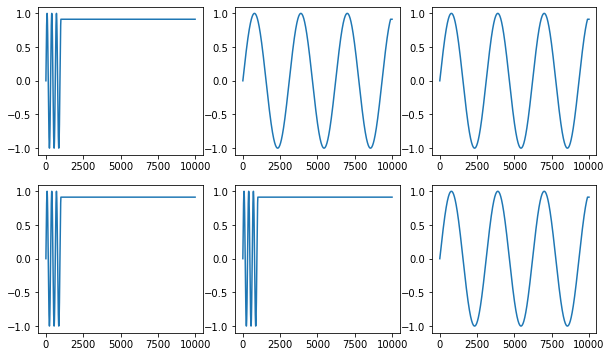

In [15]:
fig, ax = plt.subplots(2,3, figsize = (10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].plot(fake_data(10000)[0])

In [16]:
xs =[]
ys = []
for i in range(1000):
    data = fake_data(10000)
    xs.append(data[0])
    ys.append(data[1])

In [17]:
d = {"Trace":xs, "Breath_hold": ys}
df = pd.DataFrame(d)
df.head(2)

,Trace,Breath_hold
0,"[0.0, 0.0020204047270633457, 0.004040801206754...",100
1,"[0.0, 0.020018682705473478, 0.0400293421668466...",9000


In [18]:
df['class'] = np.where(df['Breath_hold']==100, 0, 1) # create encoded column: short (0), long (1)


# Split and Normalize Data

In [19]:
x_train, x_test, y_train, y_test = train_test_split(df['Trace'], df['class'], test_size=0.70)

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=1)

In [21]:
def normalize(x_train, x_val):
    u = np.mean([item for sublist in x_train for item in sublist])
    std = np.std([item for sublist in x_train for item in sublist])
    
    train = []
    for row in x_train:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        train.append(normalized_row)
    
    val = []
    for row in x_val:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        val.append(normalized_row)
    
    return train, val

In [22]:
x_train2, x_val2 = normalize(x_train, x_val)
x_train2, x_test2 = normalize(x_train, x_test)

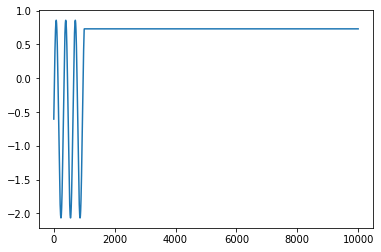

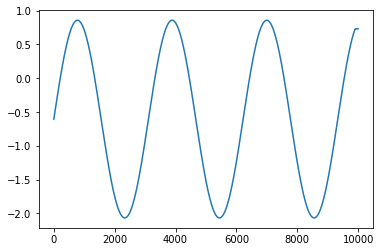

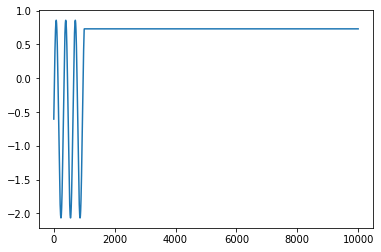

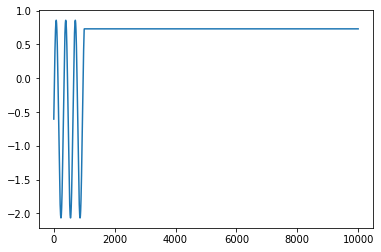

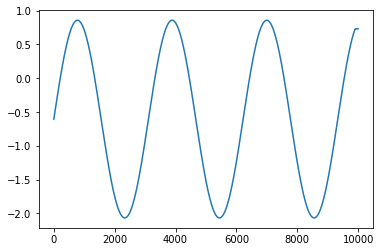

In [23]:
for i in range(5):
    j = np.random.randint(len(x_train2))
    plt.plot(x_train2[j])
    plt.show()

## Equalize Lengths

In [24]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [25]:
x_train3 = np.array(x_train2)
x_val3 = np.array(x_val2)
x_test3 = np.array(x_test2)

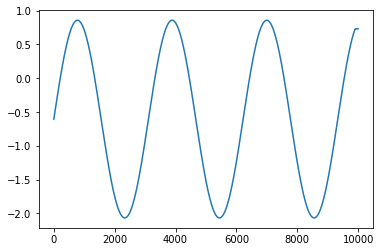

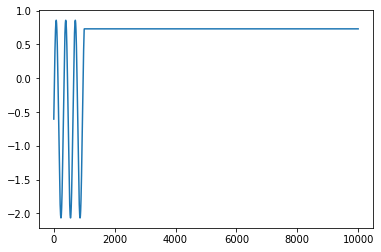

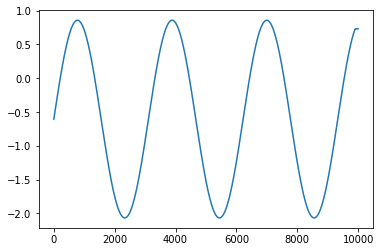

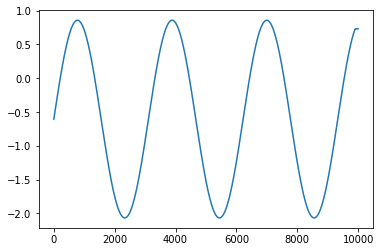

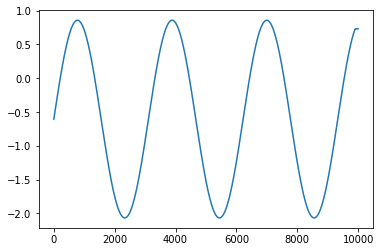

In [26]:
for i in range(5):
    j = np.random.randint(len(x_train3))
    plt.plot(x_train3[j])
    plt.show()

## CNN Model

In [27]:
class myCNN(nn.Module):
    
    def __init__(self, D):
        super(myCNN, self).__init__()
        self.conv_3 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=3)
        self.conv_4 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=4)
        self.conv_5 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=5)
        self.fc = nn.Linear(300, 1)
        
    def forward(self, x):
        x = torch.unsqueeze(x, dim=1)
        x3 = F.relu(self.conv_3(x))
        x4 = F.relu(self.conv_4(x))
        x5 = F.relu(self.conv_5(x))
        
        x3 = nn.MaxPool1d(kernel_size = 9998)(x3)
        x4 = nn.MaxPool1d(kernel_size = 9997)(x4)
        x5 = nn.MaxPool1d(kernel_size = 9996)(x5)
        
        out = torch.cat([x3, x4, x5], 2)
        out = out.view(out.size(0), -1)
        
        return self.fc(out) 

In [28]:
# Testing the model
model = myCNN(1)

In [29]:
for name, param in model.named_parameters():
    print('Name: ', name, 'Requires_Grad: ', param.requires_grad)

Name:  conv_3.weight Requires_Grad:  True
Name:  conv_3.bias Requires_Grad:  True
Name:  conv_4.weight Requires_Grad:  True
Name:  conv_4.bias Requires_Grad:  True
Name:  conv_5.weight Requires_Grad:  True
Name:  conv_5.bias Requires_Grad:  True
Name:  fc.weight Requires_Grad:  True
Name:  fc.bias Requires_Grad:  True


In [30]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Params: {total_params}")
    return total_params

count_parameters(model)

+---------------+------------+
|               | Parameters |
+---------------+------------+
| conv_3.weight |    300     |
|  conv_3.bias  |    100     |
| conv_4.weight |    400     |
|  conv_4.bias  |    100     |
| conv_5.weight |    500     |
|  conv_5.bias  |    100     |
|   fc.weight   |    300     |
|    fc.bias    |     1      |
+---------------+------------+
Total Params: 1801


1801

In [31]:
x = x_train3[:10]
x = torch.tensor(x,dtype=torch.float32)
model(x)

tensor([[1.0039],
        [1.0043],
        [1.0043],
        [1.0043],
        [1.0039],
        [1.0043],
        [1.0043],
        [1.0043],
        [1.0039],
        [1.0043]], grad_fn=<AddmmBackward0>)

# Dataset and Dataloader

In [32]:
from torch.utils.data import Dataset

class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [46]:
dataset = timeseries(x_train3, y_train)
valid_dataset = timeseries(x_val3,y_val)
test_dataset = timeseries(x_test3,y_test)

In [47]:
train_loader = DataLoader(dataset,shuffle=False,batch_size=50)
val_loader = DataLoader(valid_dataset,shuffle=False,batch_size=50)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=50)

## Training

In [52]:
#def train(model, x_train, y_train):
model = myCNN(1).cuda()

In [53]:
def train_epocs(model, epochs=10, lr=0.01, fname='1'):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    
    losses = []
    for i in range(epochs):
        model.train()
        current_loss = []
        for x, y in train_loader:
            x = x.cuda()
            y = y.unsqueeze(1).cuda()
            y_hat = model(x)
            loss = F.binary_cross_entropy_with_logits(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            current_loss.append(loss.item())
        train_loss = np.mean(current_loss)
        print('Epoch:', i)
        print("Train loss:", train_loss)
        val_loss = test_metrics(model)
        losses.append((train_loss, val_loss))
        
        
    #filename = 'losses_' + fname + '.csv'
    #np.savetxt(filename, losses, delimiter=",")
    return losses

In [54]:
def test_metrics(m):
    m.eval()
    losses = []
    for x, y in val_loader:
        x = x.cuda()
        y = y.unsqueeze(1).cuda()
        y_hat = m(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        losses.append(loss.item())
        
        y_pred = y_hat > 0
        correct = (y_pred.float() == y).float().sum()
        accuracy = correct/y_pred.shape[0]
    print("test loss %.3f and accuracy %.3f" % (np.mean(losses), accuracy))
    return np.mean(losses)

In [55]:
loss1 = train_epocs(model, epochs=200, lr=0.01)

Epoch: 0
Train loss: 0.8515917211771011
test loss 0.988 and accuracy 0.450
Epoch: 1
Train loss: 0.8168511986732483
test loss 0.767 and accuracy 0.550
Epoch: 2
Train loss: 0.7653988003730774
test loss 0.696 and accuracy 0.450
Epoch: 3
Train loss: 0.7284688800573349
test loss 0.726 and accuracy 0.450
Epoch: 4
Train loss: 0.7080340832471848
test loss 0.709 and accuracy 0.550
Epoch: 5
Train loss: 0.7085837870836258
test loss 0.694 and accuracy 0.450
Epoch: 6
Train loss: 0.7016784250736237
test loss 0.704 and accuracy 0.450
Epoch: 7
Train loss: 0.6971970647573471
test loss 0.692 and accuracy 0.550
Epoch: 8
Train loss: 0.6965569853782654
test loss 0.690 and accuracy 0.550
Epoch: 9
Train loss: 0.6939035505056381
test loss 0.696 and accuracy 0.450
Epoch: 10
Train loss: 0.6935821026563644
test loss 0.689 and accuracy 0.550
Epoch: 11
Train loss: 0.6924690902233124
test loss 0.689 and accuracy 0.550
Epoch: 12
Train loss: 0.691622868180275
test loss 0.691 and accuracy 0.550
Epoch: 13
Train loss: 0

# Loss Plots

In [56]:
val = [x[1] for x in loss1]
train = [x[0] for x in loss1]

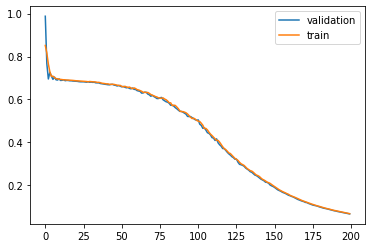

In [57]:
plt.plot(val, label = 'validation')
plt.plot(train, label = 'train')
plt.legend(loc='best')
plt.show()